# Import Libraries

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Add, Dense, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from matplotlib import pyplot
import cv2
import numpy as np

# Load Data and Split to Tarin, Valid, and Test

In [2]:
def Load_dataset():
  """
  Load the CIFAR-10 dataset

  Arguments:
  None

  Returns:
  X_train -- training set images
  y_train -- training set labels
  X_valid -- validation set images
  y_valid -- validation set labels
  X_test -- test set images
  y_test -- test set labels
  """
  # Load data
  (X_train, y_train), (X_test, y_test) = cifar10.load_data()

  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state = 0)

  # Train dataset shape
  print('Train Images Shape:', X_train.shape)
  print('Train Labels Shape:', y_train.shape)

  # Validation dataset shape
  print('\nValidation Images Shape:', X_valid.shape)
  print('Validation Labels Shape:', y_valid.shape)

  # Test dataset shape
  print('\nTest Images Shape:', X_test.shape)
  print('Test Labels Shape:', y_test.shape)


  return X_train, X_valid, y_train, y_valid, X_test, y_test

In [3]:
X_train_original, X_valid_original, y_train_original, y_valid_original, X_test_original, y_test_original = Load_dataset()

Train Images Shape: (45000, 32, 32, 3)
Train Labels Shape: (45000, 1)

Validation Images Shape: (5000, 32, 32, 3)
Validation Labels Shape: (5000, 1)

Test Images Shape: (10000, 32, 32, 3)
Test Labels Shape: (10000, 1)


# Visualize Data

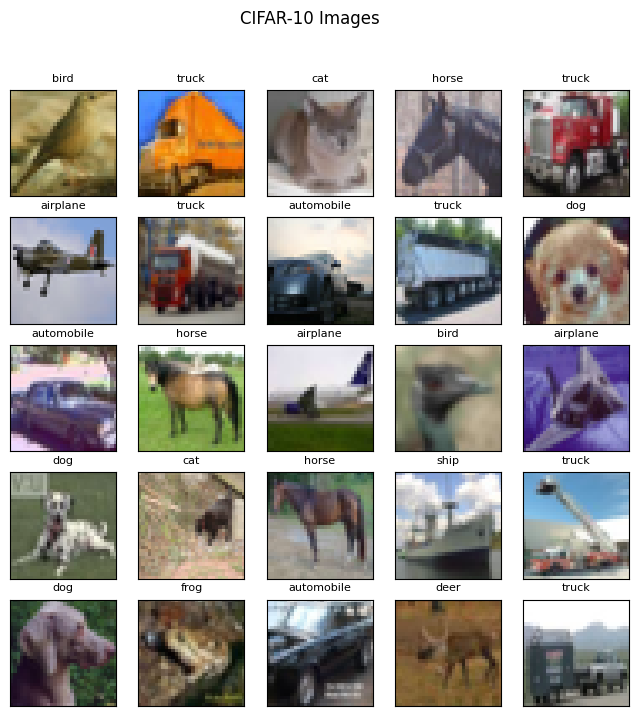

In [4]:
# Define the labels of the dataset
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

pyplot.figure(figsize=(8,8))
# Create a grid of 5x5 images and show the images with their corresponding labels
for i in range(0, 25):
  pyplot.subplot(5, 5, i+1)
  pyplot.xticks([])
  pyplot.yticks([])
  pyplot.grid(False)
  pyplot.imshow(X_train_original[i])
  pyplot.title(class_names[y_train_original[i][0]], fontsize = 8)

# Show the plot
pyplot.suptitle('CIFAR-10 Images')
pyplot.show()

# Class Distribution in Training, Validation, Test

Text(0.5, 1.0, 'Class distribution of training dataset')

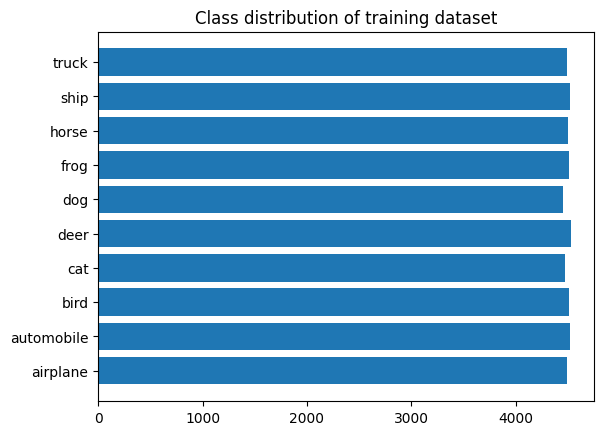

In [5]:
# Display class distribution in training dataset
classes, counts = np.unique(y_train_original, return_counts=True)
pyplot.barh(class_names, counts)
pyplot.title('Class distribution of training dataset')

Text(0.5, 1.0, 'Class distribution of validation dataset')

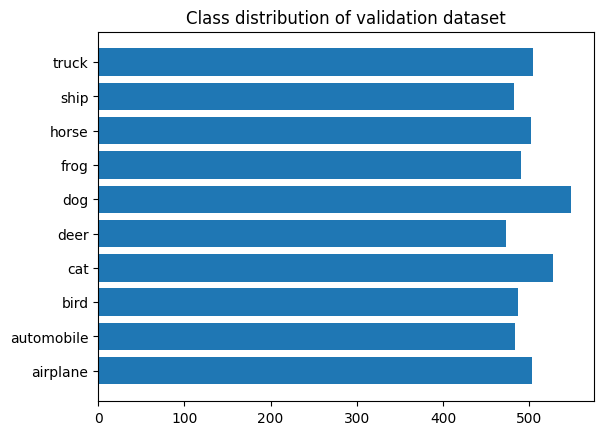

In [6]:
# Display class distribution in validation dataset
classes, counts = np.unique(y_valid_original, return_counts=True)
pyplot.barh(class_names, counts)
pyplot.title('Class distribution of validation dataset')

Text(0.5, 1.0, 'Class distribution of test dataset')

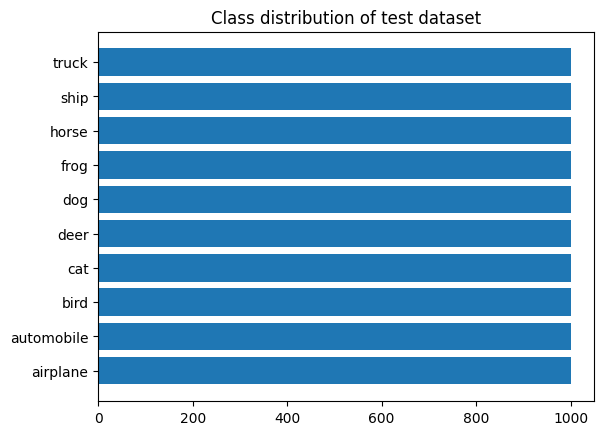

In [7]:
# Display class distribution in test dataset
classes, counts = np.unique(y_test_original, return_counts=True)
pyplot.barh(class_names, counts)
pyplot.title('Class distribution of test dataset')

# Preprocessing

In [8]:
def Preprocessing(X_train, X_valid, X_test, y_train, y_valid, y_test):
  """
  Preprocess the data for running models:
    - Normalize the images to be between 0 and 1
    - One hot encode the labels

  Arguments:
  X_train -- training set images
  X_valid -- validation set images
  X_test -- test set images
  y_train -- training set labels
  y_valid -- validation set labels
  y_test -- test set labels

  Returns:
  X_train -- training set images
  y_train -- training set labels
  X_valid -- validation set images
  y_valid -- validation set labels
  X_test -- test set images
  y_test -- test set labels
  """

  # Normalize inputs from 0-255 to 0.0-1.0
  X_train = X_train.astype('float32')
  X_valid = X_valid.astype('float32')
  X_test = X_test.astype('float32')
  X_train = X_train / 255.0
  X_valid = X_valid / 255.0
  X_test = X_test / 255.0

  # One hot encode outputs
  y_train = to_categorical(y_train)
  y_valid = to_categorical(y_valid)
  y_test = to_categorical(y_test)

  return X_train, y_train, X_valid, y_valid, X_test, y_test

In [9]:
X_train, y_train, X_valid, y_valid, X_test, y_test = Preprocessing(X_train_original,
                                                                   X_valid_original,
                                                                   X_test_original,
                                                                   y_train_original,
                                                                   y_valid_original,
                                                                   y_test_original)

# Data Augmentation

In [10]:
def data_augmentation(X_train, y_train):
  """
  Data augmentation for training dataset

  Arguments:
  X_train -- training set images
  y_train -- training set labels

  Returns:
  datagenerator -- data augmentation object
  """

  datagenerator = ImageDataGenerator(
      # Flip images horizontally
      horizontal_flip=True,
      # Randomly rotate images by up to 25 degrees
      rotation_range=25,
      # Randomly zoom images by up to 10%
      zoom_range=0.1,
      # Shift the images horizontally by up to 20% of the width
      width_shift_range=0.2,
      # Shift the images vertically by up to 20% of the height
      height_shift_range=0.2)

  # Augmentation on original training dataset for visualization
  X_train_generator = datagenerator.flow(X_train_original, y_train_original, batch_size = 64)
  batchX, batchY = X_train_generator.next()

  for j in range(0, 9):
      pyplot.subplot(330 + 1 + j)
      pyplot.imshow(batchX[j].astype('int32'))
      pyplot.axis('off')

      pyplot.title(class_names[batchY[j][0]], fontsize = 8)

  # Show the plot
  pyplot.suptitle('CIFAR-10 Images')
  pyplot.show()

  return datagenerator

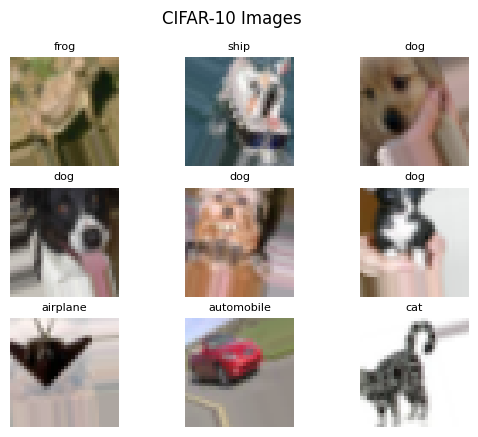

In [11]:
datagenerator = data_augmentation(X_train, y_train)
X_train_augmented = datagenerator.flow(X_train, y_train)

In [12]:
def ResBlock_model(input_shape = (32, 32, 3), classes = 10):
  """
  Implementation of the ResBlock Model

  Arguments:
  input_shape -- shape of the images of the dataset
  classes -- integer, number of classes

  Returns:
  model -- a Model() instance in Keras
  """

  # Define the input as a tensor with shape input_shape
  X_input = Input(input_shape)

  # First component of main path glorot_uniform(seed=0)
  X = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X_input)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)


  # Second component of main path glorot_uniform(seed=0)
  X = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D(pool_size=(2, 2))(X)

  # Third component of main path glorot_uniform(seed=0)
  Res1 = X
  X = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)

  # Forth component of main path glorot_uniform(seed=0)
  X = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3)(X)

  # First Shortcut path
  Res1 = Conv2D(filters=128, kernel_size=1, strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(Res1)

  # Add first shortcut value to the main path
  X = Add()([X, Res1])
  X = Activation('relu')(X)
  X = MaxPooling2D(pool_size=(2, 2))(X)

  # Fifth component of main path glorot_uniform(seed=0)
  Res2 = X
  X = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)

  # Sixth component of main path glorot_uniform(seed=0)
  X = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3)(X)

  # Second shortcut path
  Res2 = Conv2D(filters=256, kernel_size=1, strides=(1, 1), padding='same', kernel_initializer=glorot_uniform(seed=0))(Res2)

  # Add second shortcut value to the main path
  X = Add()([X, Res2])
  X = Activation('relu')(X)
  X = MaxPooling2D(pool_size=(2, 2))(X)

  # output layer
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


  # Create model
  model = Model(inputs = X_input, outputs = X)

  return model

In [13]:
res_block_model = ResBlock_model(input_shape = (32, 32, 3), classes = 10)
print(res_block_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 64)           0         ['batch_normalization[0][0

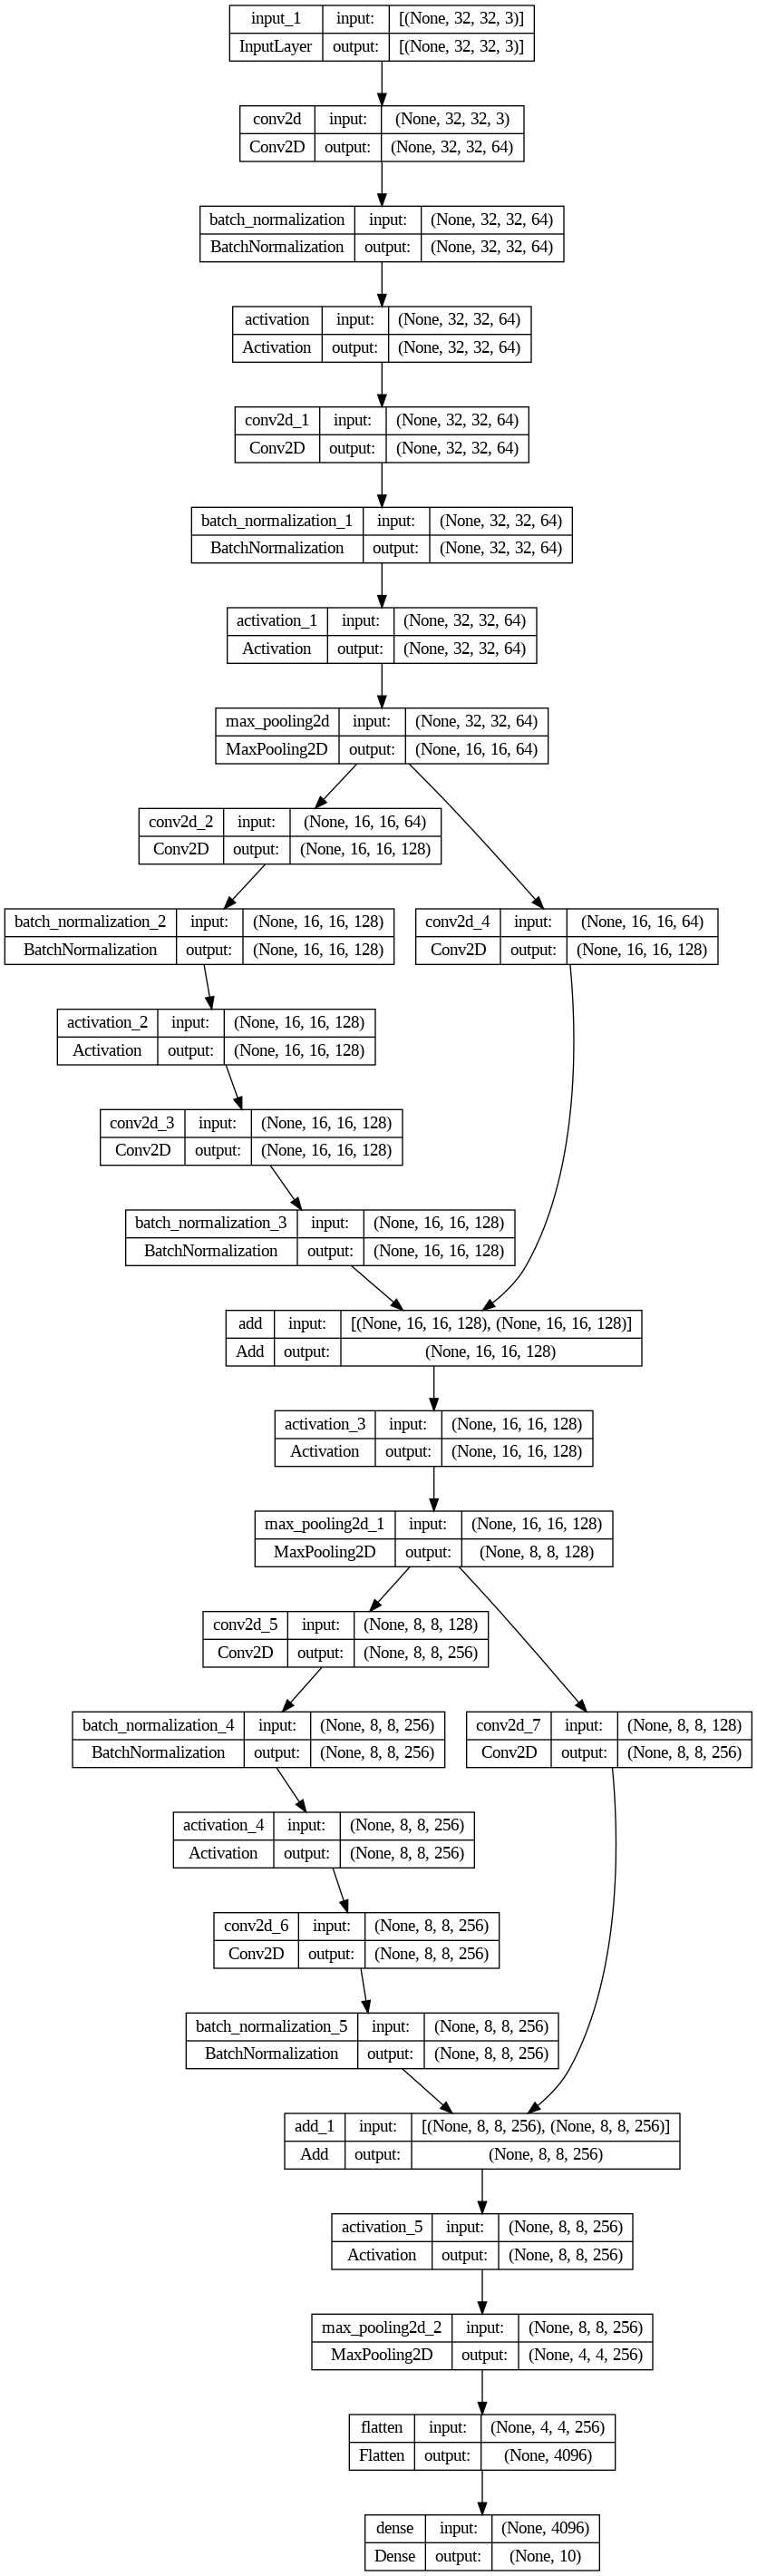

In [14]:
plot_model(res_block_model, show_shapes=True, show_layer_names=True)

In [15]:
# Set hyperparameters for training
opt = Adam(learning_rate=0.001)
res_block_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4, min_lr=0.00001)

In [16]:
history = res_block_model.fit(X_train_augmented, validation_data = (X_valid, y_valid), epochs = 50, batch_size = 64, callbacks=[reduce_lr])

Epoch 1/50
1407/1407 [==============================] - 51s 28ms/step - loss: 1.5858 - accuracy: 0.4396 - val_loss: 1.4729 - val_accuracy: 0.5044 - lr: 0.0010
Epoch 2/50
1407/1407 [==============================] - 40s 28ms/step - loss: 1.1648 - accuracy: 0.5883 - val_loss: 1.0936 - val_accuracy: 0.6270 - lr: 0.0010
Epoch 3/50
1407/1407 [==============================] - 37s 27ms/step - loss: 0.9832 - accuracy: 0.6552 - val_loss: 1.3707 - val_accuracy: 0.5596 - lr: 0.0010
Epoch 4/50
1407/1407 [==============================] - 38s 27ms/step - loss: 0.8806 - accuracy: 0.6954 - val_loss: 0.7422 - val_accuracy: 0.7458 - lr: 0.0010
Epoch 5/50
1407/1407 [==============================] - 37s 26ms/step - loss: 0.7997 - accuracy: 0.7236 - val_loss: 0.8598 - val_accuracy: 0.7234 - lr: 0.0010
Epoch 6/50
1407/1407 [==============================] - 38s 27ms/step - loss: 0.7379 - accuracy: 0.7459 - val_loss: 0.8279 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 7/50
1407/1407 [========================

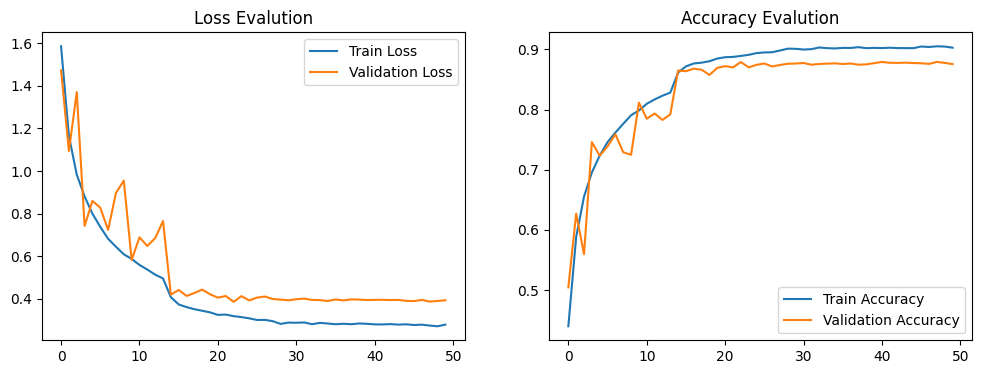

In [17]:
pyplot.figure(figsize=(12,4))

# Plotting the training and validation loss
pyplot.subplot(1, 2, 1)
pyplot.plot(history.history['loss'], label='Train Loss')
pyplot.plot(history.history['val_loss'], label='Validation Loss')
pyplot.legend()
pyplot.title('Loss Evalution')

# Plotting the training and validation accuracy
pyplot.subplot(1, 2, 2)
pyplot.plot(history.history['accuracy'], label='Train Accuracy')
pyplot.plot(history.history['val_accuracy'], label='Validation Accuracy')
pyplot.legend()
pyplot.title('Accuracy Evalution')

pyplot.show()

157/157 [==============================] - 1s 5ms/step


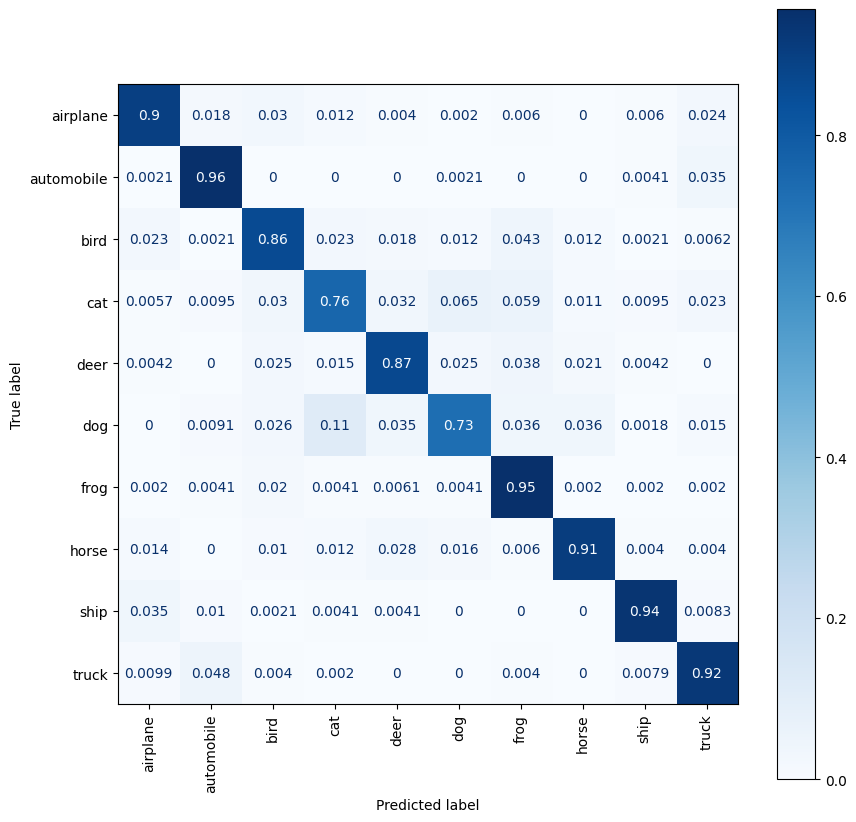

In [18]:
num_classes = 10
# Predictions on validation set
y_val_pred = res_block_model.predict(X_valid)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_valid, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val_true, y_val_pred_classes)

figsize = (10,10)
ConfusionMatrixDisplay.from_predictions(y_val_true, y_val_pred_classes,
                                        display_labels=class_names,
                                        xticks_rotation="vertical",
                                        normalize='true',
                                        cmap='Blues',
                                        ax=pyplot.subplots(figsize=figsize)[1])
pyplot.show()

In [19]:
# Evaluate test data
test_loss, test_acc = res_block_model.evaluate(X_test, y_test, verbose=1)

print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

313/313 [==============================] - 3s 8ms/step - loss: 0.4082 - accuracy: 0.8802

Test Accuracy: 0.8802000284194946

Test Loss: 0.40821099281311035
